In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # Pour visualiser l'espace latent 2D
from torchvision.utils import make_grid

# Imports locaux
from model import CCVAE
from dataset import CartoonHairColorDataset
from torchvision import transforms

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "ccvae_haircolor.pth"
DATA_DIR = "./cartoonset10k/cartoonset10k"
BATCH_SIZE = 128 # On prend un gros batch pour avoir plein de points pour le t-SNE

print(f"Working on {DEVICE}")

Working on cuda


In [2]:
# 1. Dataset & Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = CartoonHairColorDataset(root_dir=DATA_DIR, transform=transform)
# Shuffle=True pour avoir des classes variées
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 2. Charger le modèle
# Attention : Assure-toi que ces dimensions matchent ton entraînement (16/64 ou 16/32 ?)
model = CCVAE(img_channels=3, z_c_dim=16, z_not_c_dim=64, num_classes=10).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Modèle chargé et en mode eval().")

# 3. Récupérer un batch de référence
data_iter = iter(test_loader)
fixed_x, fixed_y = next(data_iter)
fixed_x = fixed_x.to(DEVICE)
fixed_y = fixed_y.to(DEVICE)

Modèle chargé et en mode eval().


## Basic blocks

In [3]:
def encode_to_z(model, x):
    """
    x : (1, 3, 64, 64)
    Retourne :
        z, z_c, z_not_c  (tensors 1×dim)
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        logvar = model.fc_logvar(h)
        z = model.reparameterize(mu, logvar)

        z_c = z[:, :model.z_c_dim]
        z_not_c = z[:, model.z_c_dim:]

    return z, z_c, z_not_c

def probas_from_zc(model, z_c):
    """
    z_c : (1, z_c_dim)
    Retourne les probas q(y|z_c)
    """
    with torch.no_grad():
        logits = model.classifier(z_c)
        probs = F.softmax(logits, dim=1)
    return probs

def classify_x(model, x):
    """
    x : (1, 3, 64, 64)
    Retourne :
        - pred (entier)
        - probs (1, num_classes)
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        z_c = mu[:, :model.z_c_dim]  # version déterministe

        logits = model.classifier(z_c)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    return pred, probs

def generate_random(model, device='cuda'):
    """
    Génère une image en échantillonnant z_c et z_not_c ~ N(0,I)
    """
    with torch.no_grad():
        z_c = torch.randn(1, model.z_c_dim).to(device)
        z_not_c = torch.randn(1, model.z_not_c_dim).to(device)
        z = torch.cat([z_c, z_not_c], dim=1)

        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen

def generate_conditional(model, class_idx, device='cuda'):
    """
    Génère une image appartenant à une classe donnée (hair_color = class_idx)
    """
    with torch.no_grad():
        y = torch.tensor([class_idx], device=device)
        y_onehot = F.one_hot(y, num_classes=model.num_classes).float()

        y_embed = model.y_embedding(y_onehot)
        z_c = model.cond_prior_mu(y_embed)   # moyenne du prior
        z_not_c = torch.randn(1, model.z_not_c_dim).to(device)

        z = torch.cat([z_c, z_not_c], dim=1)

        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_tensor_image(img_tensor, title="Image générée"):
    """
    img_tensor : (1, 3, 64, 64)
    Affiche l'image.
    """
    img = img_tensor.squeeze(0).detach().cpu()        # (3,64,64)
    img = img.permute(1, 2, 0).numpy()                # (64,64,3)
    img = np.clip(img, 0, 1)                          # Sécurité

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
# x_test=fixed_x
# On prend la 1ère image du dataset
x_test, y_test = dataset[0]

# Le modèle attend un batch → on ajoute une dimension batch : (1,3,64,64)
x_test = x_test.unsqueeze(0).to(DEVICE)
y_test = torch.tensor([y_test], device=DEVICE)

print(x_test.shape)
z,zc,z_not_c=encode_to_z(model,x_test)
print(z.shape)
print(zc.shape)
print(z_not_c.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 80])
torch.Size([1, 16])
torch.Size([1, 64])


In [6]:
probas_from_zc(model,zc).shape

torch.Size([1, 10])

In [7]:
print(classify_x(model,x_test))
print(y_test)

(9, tensor([[8.0476e-02, 1.2692e-03, 6.2022e-04, 1.3179e-04, 1.3595e-03, 1.2916e-04,
         1.8413e-05, 2.0146e-07, 5.2000e-02, 8.6400e-01]], device='cuda:0'))
tensor([9], device='cuda:0')


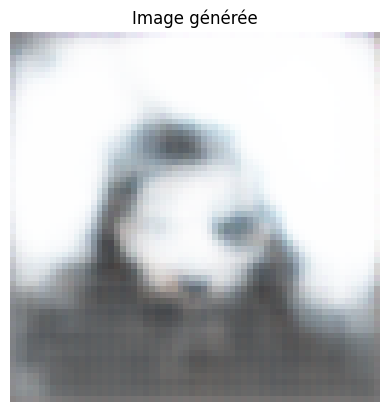

In [8]:
show_tensor_image(generate_random(model))

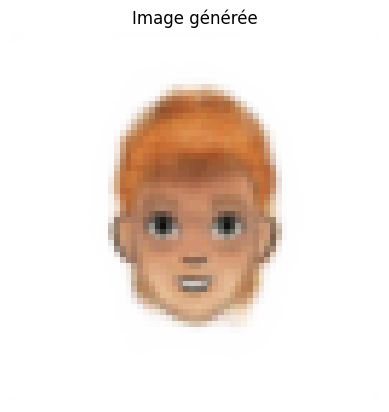

In [80]:
show_tensor_image(generate_conditional(model,3))

## Experiments

### Experiment 1 - Reconstruction Quality

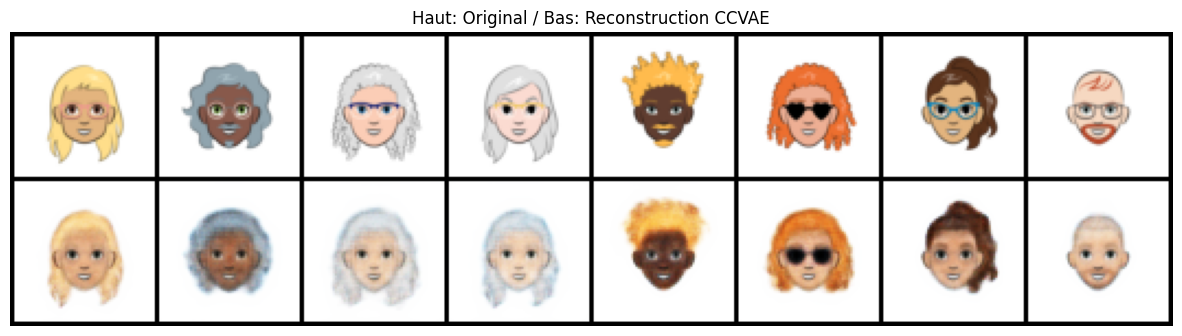

In [10]:
def show_recons(x, model):
    with torch.no_grad():
        recon_x, _, _, _, _, _ = model(x)
    
    # On colle Input et Recon l'une sous l'autre
    comparison = torch.cat([x[:8], recon_x[:8]])
    grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Haut: Original / Bas: Reconstruction CCVAE")
    plt.show()

show_recons(fixed_x, model)

### Experiment 2 - Latent Space Audit (t-SNE)

On extrait les vecteurs $z_c$ (caractéristiques) de tout le batch et on les projette en 2D.
- Attendu : On doit voir 10 clusters bien séparés (un par couleur de cheveux).Si c'est un nuage informe mélangé, le modèle a échoué.

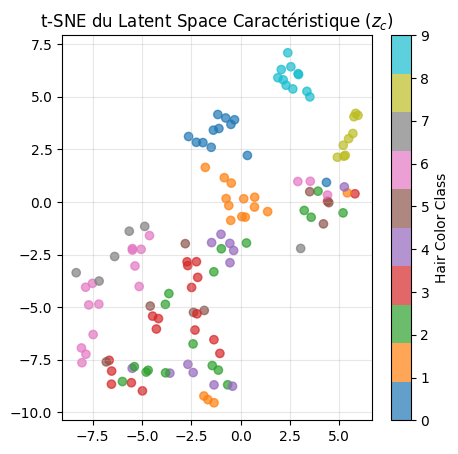

In [11]:
def visualize_latent_space(x, y, model):
    with torch.no_grad():
        # Encode
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        # On ne prend QUE la partie Z_c (les 16 premières dimensions)
        z_c = mu[:, :model.z_c_dim].cpu().numpy()
        labels = y.cpu().numpy()

    # t-SNE projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    z_embedded = tsne.fit_transform(z_c)

    # Plot
    plt.figure(figsize=(5, 5))
    scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label="Hair Color Class")
    plt.title("t-SNE du Latent Space Caractéristique ($z_c$)")
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_latent_space(fixed_x, fixed_y, model)

### Experiment 3 - The "Swap Matrix"

C'est la visualisation classique des papiers de recherche (comme dans Lord et al.).

- Ligne du haut : Les sources de "Style" (Couleur).

- Colonne de gauche : Les sources de "Contenu" (Forme visage).

- Intérieur : Le mix des deux.

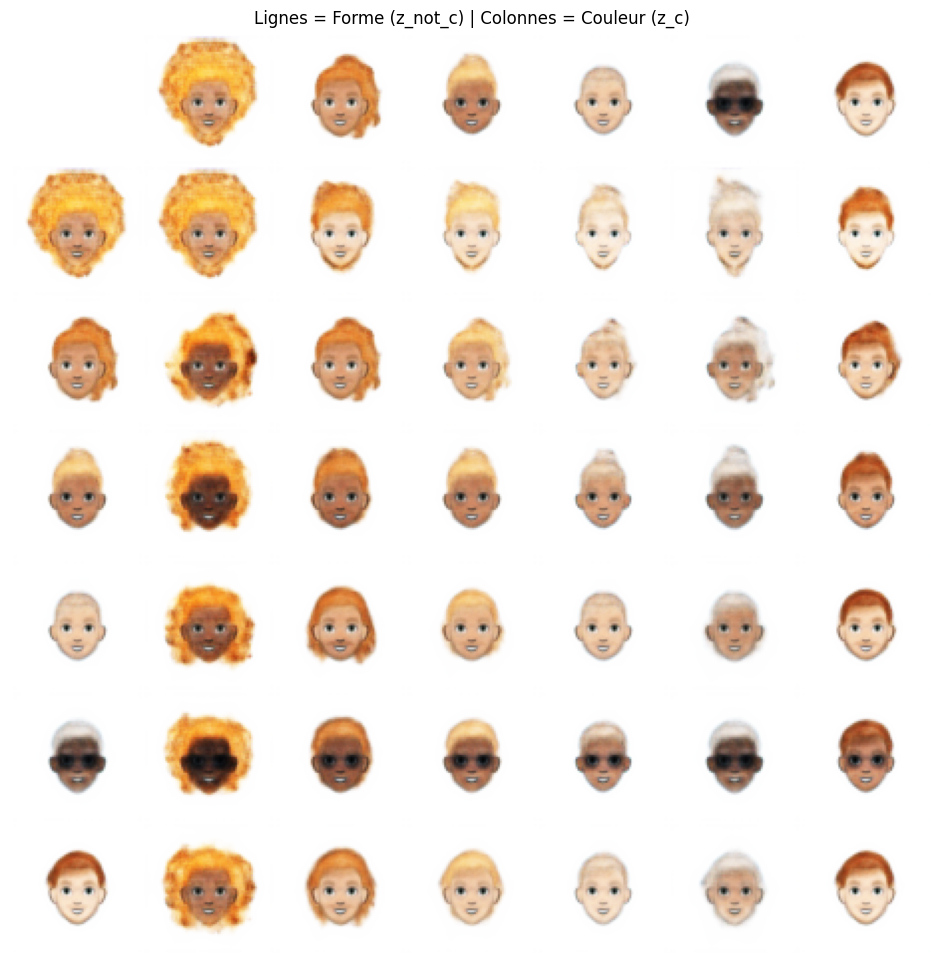

In [12]:
def plot_disentanglement_matrix(model, dataset, num_examples=6):
    """
    Génère une matrice où :
    - La 1ère ligne donne la COULEUR (z_c)
    - La 1ère colonne donne la FORME (z_not_c)
    """
    model.eval()
    
    # On pioche quelques images au hasard
    idxs = np.random.choice(len(dataset), num_examples, replace=False)
    samples = torch.stack([dataset[i][0] for i in idxs]).to(DEVICE)
    
    with torch.no_grad():
        # Encodage complet
        h = model.encoder_conv(samples)
        mu = model.fc_mu(h)
        
        # Séparation
        z_c_all = mu[:, :model.z_c_dim]      # Source de couleur
        z_not_c_all = mu[:, model.z_c_dim:]  # Source de forme
        
        # Création de la matrice d'images
        # Taille grille : (num_examples + 1) x (num_examples + 1)
        
        # On prépare une liste vide pour stocker les lignes
        rows = []
        
        # 1. Première ligne : Les sources de COULEUR (on met un carré blanc en haut à gauche)
        # On reconstruit juste les images originales pour référence
        rec_originals = model.decoder_conv(
            model.decoder_input(mu).view(-1, 64, 4, 4)
        )
        
        # Le coin haut-gauche est vide (blanc)
        white_square = torch.ones_like(samples[0:1])
        header = torch.cat([white_square, rec_originals], dim=0)
        rows.append(header)
        
        # 2. Remplissage de la grille
        for i in range(num_examples):
            # i est l'index de l'image qui donne la FORME (z_not_c)
            # On veut combiner la forme i avec la couleur de j (pour tout j)
            
            z_shape_i = z_not_c_all[i : i+1] # (1, dim)
            z_shape_repeated = z_shape_i.repeat(num_examples, 1) # (N, dim)
            
            # On combine avec TOUTES les couleurs
            z_combined = torch.cat([z_c_all, z_shape_repeated], dim=1) # (N, total_dim)
            
            # Décodage
            dec_in = model.decoder_input(z_combined).view(-1, 64, 4, 4)
            generated = model.decoder_conv(dec_in)
            
            # On ajoute l'image source de forme au début de la ligne
            row_i = torch.cat([rec_originals[i:i+1], generated], dim=0)
            rows.append(row_i)
            
        # Assemblage final
        final_grid_tensor = torch.cat(rows, dim=0)
        
        # Affichage
        plt.figure(figsize=(12, 12))
        grid_img = make_grid(final_grid_tensor.cpu(), nrow=num_examples + 1, padding=2, pad_value=1)
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Lignes = Forme (z_not_c) | Colonnes = Couleur (z_c)")
        plt.show()

plot_disentanglement_matrix(model, dataset)